<h1>Kernelized Ridge Regression using Linear, Polynomial </h1>

RR（Ridge Regression，岭回归）																									
问题： 最小二乘法当数据集合存在多重线性（病态矩阵）时，计算出的 w数值很大，使得在线性模型  $y=w^T$中，当输入变量 x 有微小变动时，输出变量 y 就会很大。即该线性回归模型对 x  的噪音很敏感。																									
解决思路： 限制参数 w  的大小，使其不会变的很大，减少对噪音的敏感度。在原来回归模型的基础上加一个惩罚项，称为正则化（Regularization）。																									
1. LASSO（Least absolute shrinkage and selection operator）回归： 惩罚项是 w  的 $ l_1 $ 范数，如下式。																									
$J(w)=(y-Xw)^2+\lambda||w||_1 \ \ \ \ \ \ \ (1) $																							
2. 岭回归： 惩罚项是 w  的 $ l_2 $范数，如下式。																									
$ J(w)=(y-Xw)^2+\lambda||w||_2^2 \ \ \ \ \ \ \ (2) $																								
将 J ( w ) J(w) J(w) 对 w w w 求导数等于0，得到																									
$J'(w)=-2X^T(y-Xw)+2\lambda w=0 \ \ \ \ \ \ \ (3) $														
解得:																									
$ w=(X^TX+\lambda I)^{-1}X^Ty \ \ \ \ \ \ \ (4) $																								
KRR（Kernal Ridge Regression，核岭回归）																									
改进的问题： RR只能处理线性数据，引入核函数后，能够处理非线性数据，将数据映射到某一个核空间，使得数据在这个核空间上线性可分。																									
推导过程： 由于公式(4)的有一项X没有办法写成内积的形式，因此使用矩阵求逆引理（Matrix inversion lemma）推导得到如下公式。																									
$ w=X^T(XX^T+\lambda I_N)^{-1}y \ \ \ \ \ \ \ (5) $																									
下面将其kernal化，令对偶变量 $α  = (K+ \lambda I_N)^{-1}y $，其中$ K =XX^T $，
可写为 $ w=X^T\alpha=\sum_{i=1}^N \alpha _i x_i $于是，对于一个新样本 $x^*$，可通过下式预测$ y^* $ :																								
$y^*=w^Tx^*=\sum_{i=1}^N\alpha_ix_i^Tx^*=\sum_{i=1}^N\alpha_ik(x^*,x_i) \ \ \ \ \ \ \ (6) $																									

##  直接从希尔伯特空间看
在高维空间拟合 $f(\hat{x})=\sum_{i=1}^{n} \alpha_{i} k\left(x_{i}, x\right)$  <br>
已经有的数据是 $\left\{x_{i}, f_{i}\right\}(i=1, \cdots, n)$, 于是我们寻找合适的参数 $\vec{\alpha}$ 来最小化  <br>
$\sum_{j=1}^{n}\left\|f_{j}-\sum_{i=1}^{n} \alpha_{j} k\left(x_{i}, x_{j}\right)\right\|^{2}$  <br>
加入正则化项 , 即 $\lambda\|f\|_{\mathscr{H}}^{2}=\lambda \alpha^{T} K \alpha\left(K\right.$ 是矩阵, $\left.K_{i j}=k\left(x_{i}, x_{j}\right), \lambda>0\right)$, <br>
整个
优化目标变成<br>
$\sum_{j=1}^{n}\left\|f_{j}-\sum_{i=1}^{n} \alpha_{j} k\left(x_{i}, x_{j}\right)\right\|^{2}+\lambda \alpha^{T} K \alpha$<br>
最优解为 $\alpha=(K+\lambda I)^{-1} y$ 。

In [11]:
from sklearn.model_selection import KFold
import pandas as pd
from csv import reader
import csv
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist,squareform
from numpy import exp
from math import sqrt

Loading the data set

For our implementation, we have split the dataset set into two CSV files:

1) predictors.csv - contains all the predictor variables (each column represents single predictor variable).   Currently, we are considering 7 predictor varibles

2) response.csv - contains only response variables.

In [12]:
import os
os.chdir(r"E:\2021秋学期\论文学习\论文学习\Kernelized-Ridge-Regression-master\Kernelized-Ridge-Regression-master")
XMat = pd.read_csv('predictors.csv')
XmatrixInti = XMat.values

'''We have consiered then convert thus obtained data matrix into Dataframes using pandas library '''
X = pd.DataFrame(XmatrixInti)
X=X[:1000]

print(X.shape)

Y= pd.read_csv('response.csv')
Y=Y[:1000]
print(Y.shape)

(1000, 7)
(1000, 1)


<h3> Unit Testing using Trivial Data</h3>

The data below is our sample trivial data for the unit testing of our implementation. The sample data is the part of Abalone dataset. The first 200 data samples are considered as the training set and data samples from 100 to 300 are reserved for testing. Also, we consider only one attribute from the predictors (X dataset).

In [14]:

trivial_x_train=X[0:200]
trivial_x_train=trivial_x_train[4]
trivial_x_train=pd.DataFrame(trivial_x_train)
trivial_y_train=Y[0:200]


trivial_x_test=X[100:300]
trivial_x_test=trivial_x_test[4]
trivial_x_test=pd.DataFrame(trivial_x_test)
trivial_y_test=Y[100:300]


trivial_y_test.shape

(200, 1)

<h3>Computation of linear kernel</h3>

Formula for ridge regression: $y(x) = (K(x)^T) ((K + \lambda * I) * t)$

Linear Kernel is given by, K = x * x' -> dot product of two vectors

First term: $(K(x)^T)$ - This is the dot product of X_train and X_test.

Gram matrix: The kernel (K) in the second term is termed as Gram Matrix. For computation of gram matrix, we consider the dot product of the input vectors (X_train * X_train.T).

$\lambda $: is a scalar hyper parameter. This is multiplied by the identity matrix whose shape is same as the gram matrix.

Then, we compute the sum of Gram Matrix and Lamda which is then multiplied with the response matrix (Y_train). This becomes our linear regression model.



In [15]:
def computeLinearKernel(X_train, y_train,lamda):
    
    m,n=y_train.shape
    betaLinearKernel=np.zeros((m,n))
    I=(np.identity(m))
    betaLinearKernel=np.dot(np.linalg.pinv(np.dot(X_train,np.transpose(X_train))+(lamda*I)),y_train)
    return betaLinearKernel
    

<h3>Prediction</h3>

Now, for the prediction, we take the dot product of first kernel and our linear regression model. This is the array of predicted values

In [20]:
def predictWithLinearKernel(X_test,y_test,betaLinearKernel,X_train):
    X_test_1=X_test.values
    X_train_1=X_train.values
    y_pred= np.dot((np.dot(X_test,X_train.T)),betaLinearKernel)
    return y_pred


Plotting the graph for trivial dataset. This is done for all the kernel implementations. Please note that the hyperparameters selected for unit testing are the best parameters we obtained for the best model for our dataset

In [21]:
def plotGraph(trivial_x_train,trivial_y_train,trivial_x_test,y_pred,kernal_type):
    plt.scatter(np.squeeze(np.asarray(trivial_x_train)),np.squeeze(np.asarray(trivial_y_train)))
    plt.plot(np.squeeze(np.asarray(trivial_x_test)),np.squeeze(np.asarray(y_pred)),'r-')
    plt.xlabel('Whole weight')
    plt.ylabel('Predicted no of rings')
    if(kernal_type=='Linear'):
        plt.title('Linear Kernel')
    if(kernal_type=='Polynomial'):
        plt.title('Polynomial Kernel')
    if(kernal_type=='Gaussian'):
        plt.title('Gaussian Kernel')
    plt.show()

In [22]:
def plotLinearKernelGraph(trivial_x_train,trivial_y_train,trivial_x_test,trivial_y_test):
    betaLinearKernel=computeLinearKernel(trivial_x_train,trivial_y_train,0.5)
    y_predLin=predictWithLinearKernel(trivial_x_test,trivial_y_test,betaLinearKernel,trivial_x_train)
    plotGraph(trivial_x_train,trivial_y_train,trivial_x_test,y_predLin,'Linear')
    rms = sqrt(mean_squared_error(trivial_y_test, y_predLin))
    print('RMSE for Linear Kernel with trivial data:',rms)

<h3>Linear Kernel</h3>

Ridge regression using Linear Kernel implementation is done on the trivial data and results are visualized graphically. The performance of the same is recorded- The RMSE is 4.63

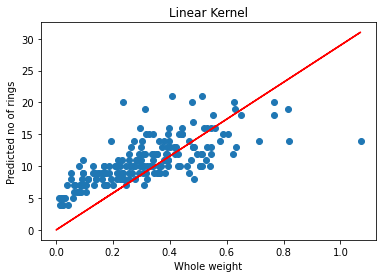

RMSE for Linear Kernel with trivial data: 4.628881646320758


In [23]:
plotLinearKernelGraph(trivial_x_train,trivial_y_train,trivial_x_test,trivial_y_test)

<h3>Polynomial Kernel</h3>

Ridge regression using Polynomial Kernel implementation is done on the trivial data and results are visualized graphically. The performance of the same is recorded- The RMSE is 2.678

In [26]:
def plotPolynomialKernelGraph(trivial_x_train,trivial_y_train,trivial_x_test,trivial_y_test):
    betaPolynomialKernel=computePolynomianKernel(trivial_x_train,trivial_y_train,1,0.01,2)
    y_predPoly=predictWithPolynomialKernel(trivial_x_test,trivial_y_test,betaPolynomialKernel,trivial_x_train,1)
    plotGraph(trivial_x_train,trivial_y_train,trivial_x_test,y_predPoly,'Polynomial')
    rms = sqrt(mean_squared_error(trivial_y_test, y_predPoly))
    print('RMSE for Polynomial Kernel with trivial data:',rms)

<h3> Computation of Polynomial Kernel</h3>

Polynomial Kernel is given by,$ K = (\gamma *  ( x * x') + R)^M $

Polynomial Kernel:$ (\gamma * (x * x') + R)^M $-  where, x is the X_train vector matrix and x' is the X_test vector matrix.

Gram matrix: The kernel (K) in the second term is termed as Gram Matrix. For computation of gram matrix, we consider the dot product of the input vectors $(\gamma * ( X\_train * X\_train.T) + R ) ^ M) $. 

$\gamma$: This is the scalar hyper parameter

R - This is hyperparameter vector matrix whose shape is same as that of the gram matrix.

$\lambda$: is a scalar hyper parameter. This is multiplied by the identity matrix whose shape is same as the gram matrix.

M- Power of the gram matrix.

Then, we compute the sum of Gram Matrix and Lamda which is then multiplied with the response matrix (Y_train). This becomes our Polynomial regression model.

In [33]:
def computePolynomianKernel(X_train,y_train,gamma,lamda,power):
    m,n=y_train.shape
    
    betaPolynomialKernel=np.zeros((m,n))
    I=(np.identity(m))
    R=np.ones((m,m))
    dotProd=np.dot(X_train,np.transpose(X_train))
    gammaProd=gamma*dotProd
    RGamma=gammaProd+R
    RGammaSquared=RGamma**power
    lamdaI=lamda*I
    RGammaSquaredPlus=RGammaSquared+lamdaI
    InVprod=np.linalg.pinv(RGammaSquaredPlus)
    betaPolynomialKernel=np.dot(InVprod,y_train)
    return betaPolynomialKernel

Now, for the prediction, we take the dot product of first kernel and our Polynomial regression model. This is the array of predicted values

In [38]:
def predictWithPolynomialKernel(X_test,y_test,betaPolynomialKernel,X_train,gamma):
    X_test_1=X_test.values
    X_train_1=X_train.values
    dotProd=np.dot(X_test_1,X_train_1.T)
    R=np.ones(dotProd.shape)
    gammaProd=gamma*dotProd
    RGamma=gammaProd+R
    RGammaSquared=np.multiply(RGamma,RGamma)
    y_pred= np.dot(RGammaSquared,betaPolynomialKernel)
    return y_pred
    

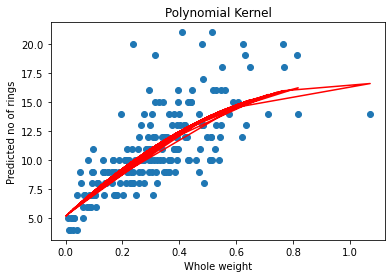

RMSE for Polynomial Kernel with trivial data: 2.67732192970615


In [39]:
plotPolynomialKernelGraph(trivial_x_train,trivial_y_train,trivial_x_test,trivial_y_test)